# 0. Import packages and Load data


In [1]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

# load data
df_fin = pd.read_csv('financial_statements.csv')
df_daily = pd.read_feather('security_daily.ftr')

In [2]:
df_fin

,datadate_x,tic,name,gsector,market_cap,PBR,PER,EPS,ROE,net_income,net_cash_flow,volatility
0,20210104,PNW,PINNACLE WEST CAPITAL CORP,utilities,8.905297e+09,1.099,18.112,5.63,0.082,550.559,49.685,0.016509
1,20210104,ABT,ABBOTT LABORATORIES,health_care,1.933824e+11,6.183,96.174,1.89,0.107,4473.000,2907.000,0.013776
2,20210104,ALK,ALASKA AIR GROUP INC,industrial,6.089215e+09,1.627,10.233,-5.64,-0.145,-1324.000,1154.000,0.035188
3,20210104,MATX,MATSON INC,industrial,2.442149e+09,1.944,20.084,2.86,0.107,193.100,-8.700,0.030216
4,20210104,Y,ALLEGHANY CORP,financial,8.430382e+09,1.005,26.306,-1.75,-0.003,101.754,-411.621,0.021499
...,...,...,...,...,...,...,...,...,...,...,...,...
2089,20210104,NES,NUVERRA ENVIRONMENTAL SOLUTN,energy,3.280576e+07,0.243,-0.513,-4.73,-0.436,-44.143,9.990,0.062768
2090,20210104,MHH,MASTECH DIGITAL INC,industrial,1.752520e+08,3.142,32.530,0.91,0.206,9.861,4.883,0.036276
2091,20210104,ISDR,ISSUER DIRECT CORP,IT,6.473660e+07,2.384,58.476,0.50,0.070,2.106,3.785,0.031666
2092,20210104,AMPE,AMPIO PHARMACEUTICALS INC,health_care,2.738814e+08,27.435,-20.666,-0.07,-2.600,-15.894,10.814,0.100264


# 1. Select variables and pre-processing data



## Select variables


In [3]:
features = ['market_cap', 'PER', 'EPS',
            'ROE', 'net_income', 'net_cash_flow', 'volatility']

## EDA for features



In [4]:
def histogram_boxplot(data, feature, figsize=(10, 5), kde=True, bins=50):
    """
    This is a function to plot a boxplot and a histogram along the same scale
    :data: dataframe
    :feature: dataframe column
    :figsize: size of figure
    :kde: whether to the show density curve
    :bins: number of bins for histogram
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

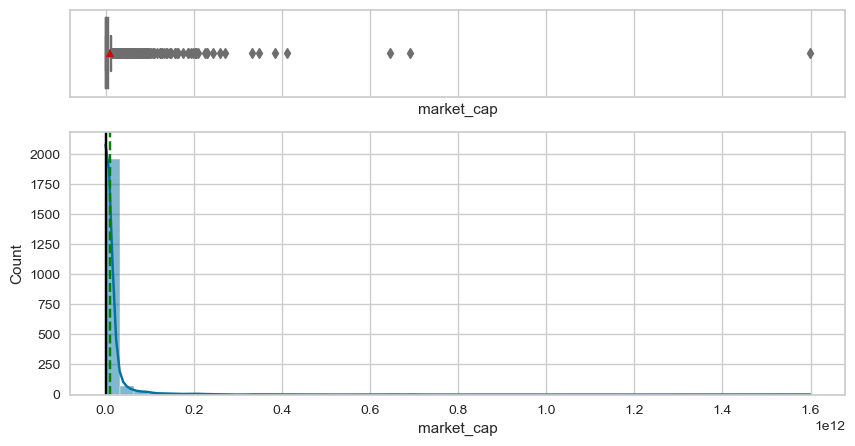

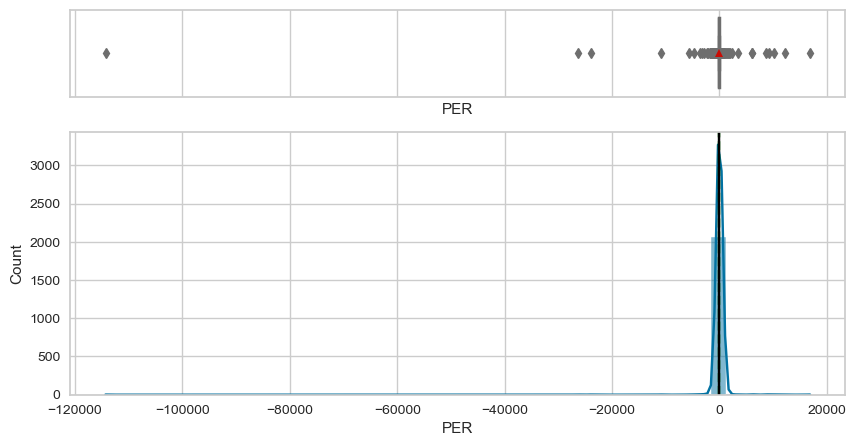

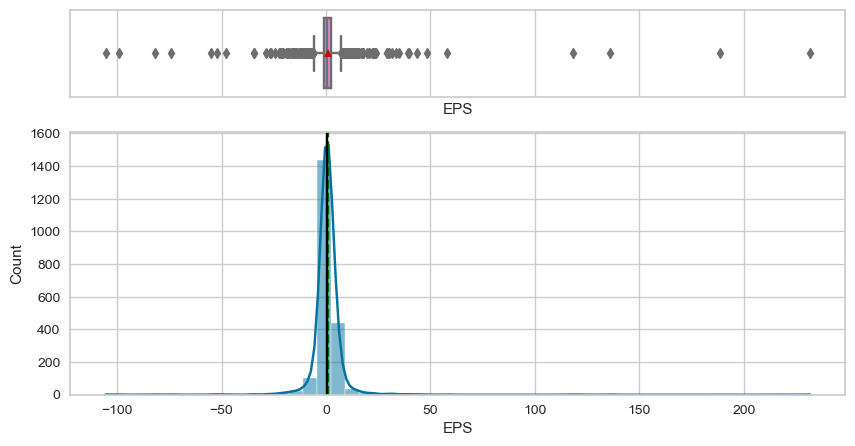

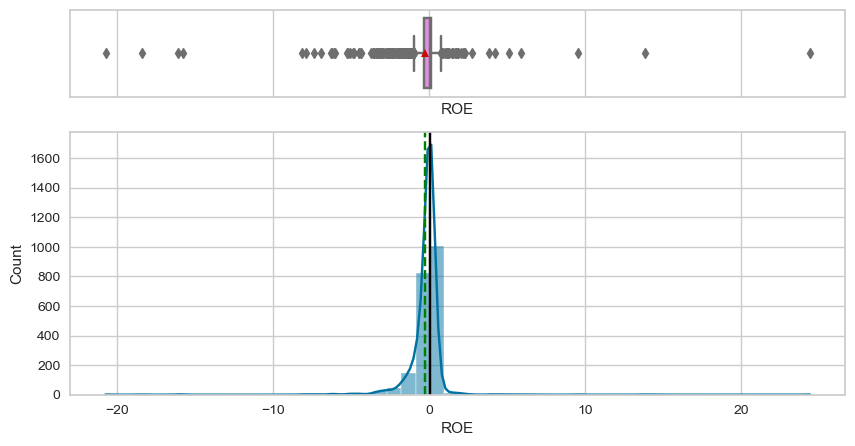

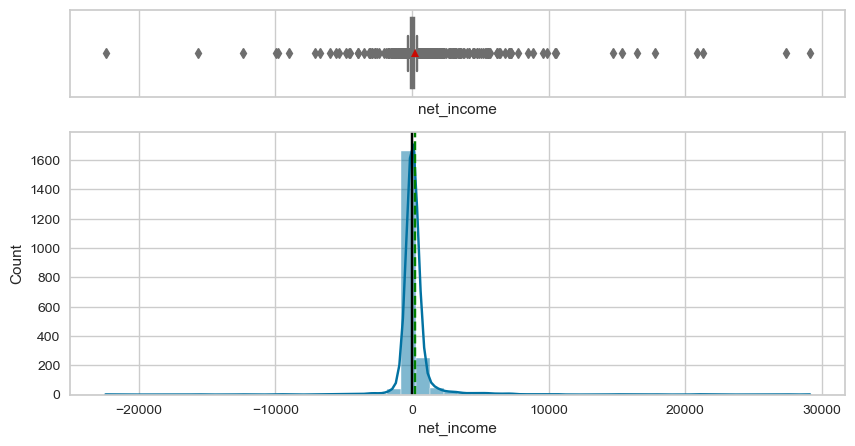

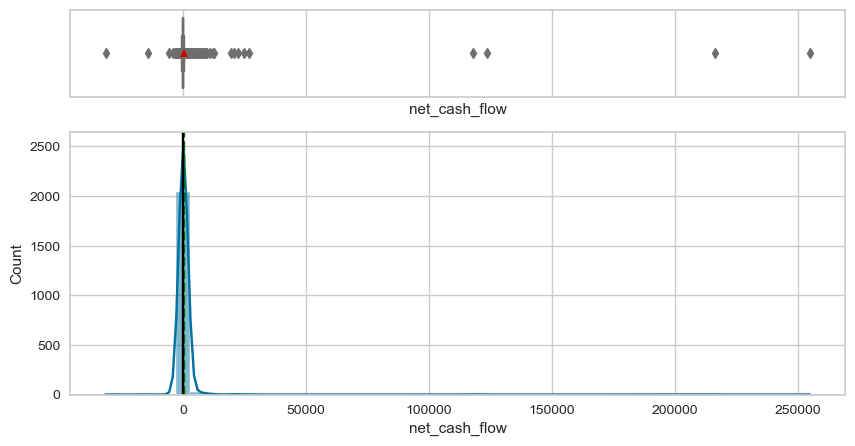

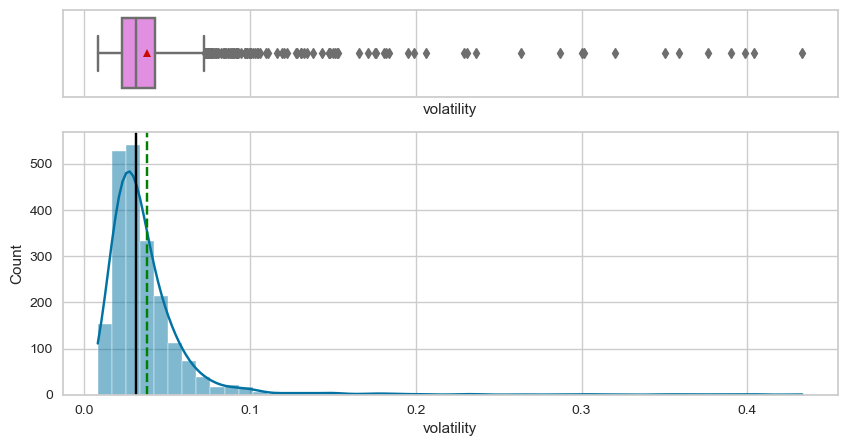

In [5]:
# see distributions of each feature

for f in features:
    histogram_boxplot(df_fin, feature=f)

## Data pre-processing



In [6]:
# remove outliers
features = ['EPS', 'net_income', 'PER', 'ROE', 'net_cash_flow']
for f in features:
    min = np.quantile(df_fin[f], 0.03)
    max = np.quantile(df_fin[f], 0.97)
    df_fin = df_fin[(df_fin[f] >= min) & (df_fin[f] <= max)]

# log transformation
df_fin['log_market_cap'] = np.log1p(df_fin['market_cap'].astype(float))

# standardization
features = ['log_market_cap', 'volatility', 'EPS',
            'PER', 'ROE', 'net_cash_flow', 'net_income']
sc = StandardScaler()
scaled = sc.fit_transform(df_fin[features])
df_fin_scaled = pd.DataFrame(scaled, columns=features)

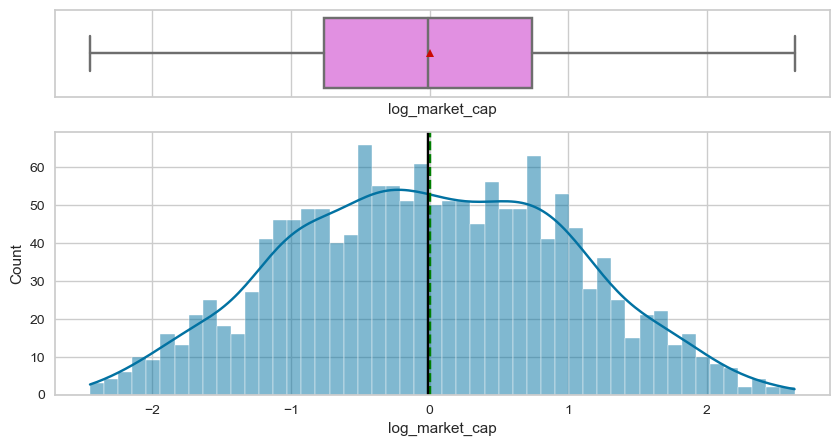

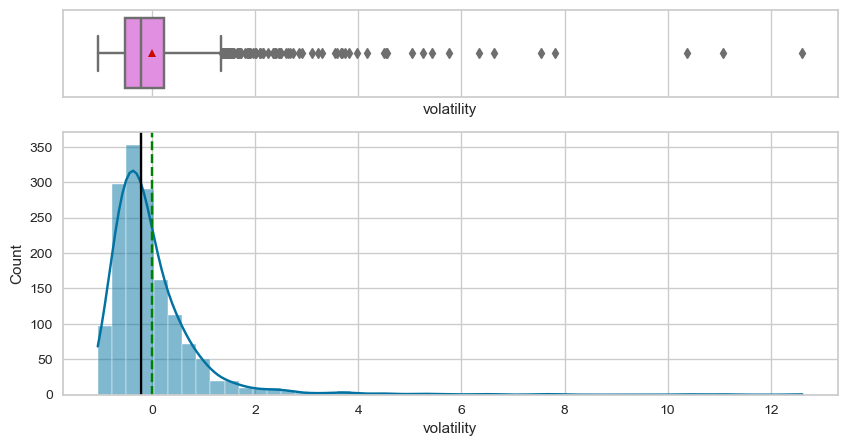

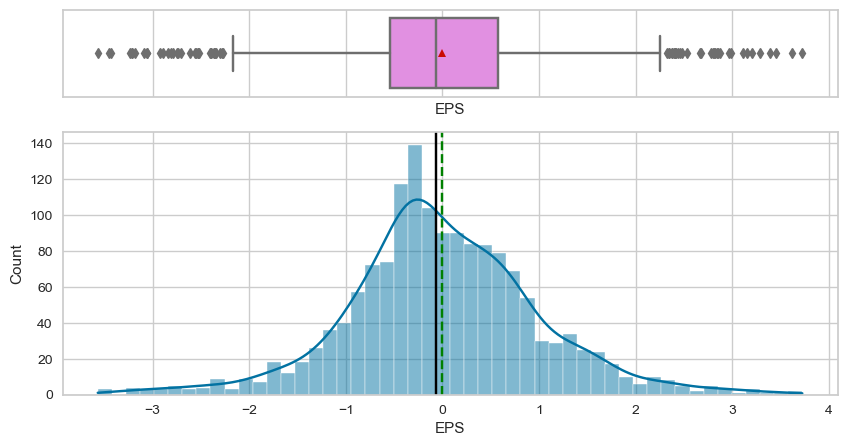

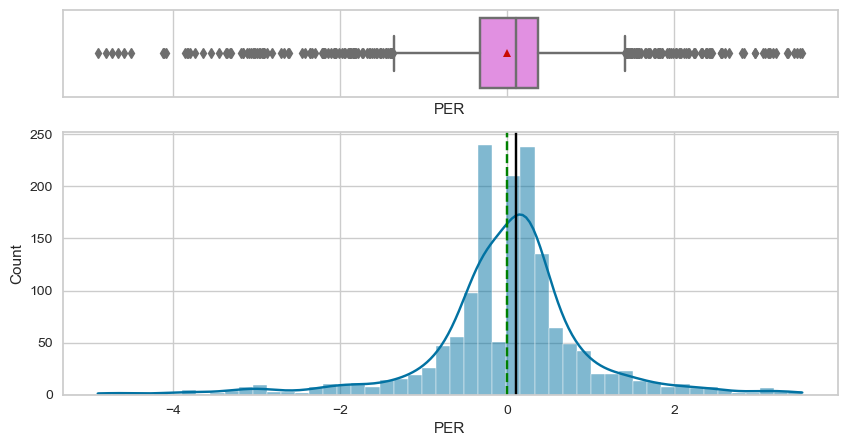

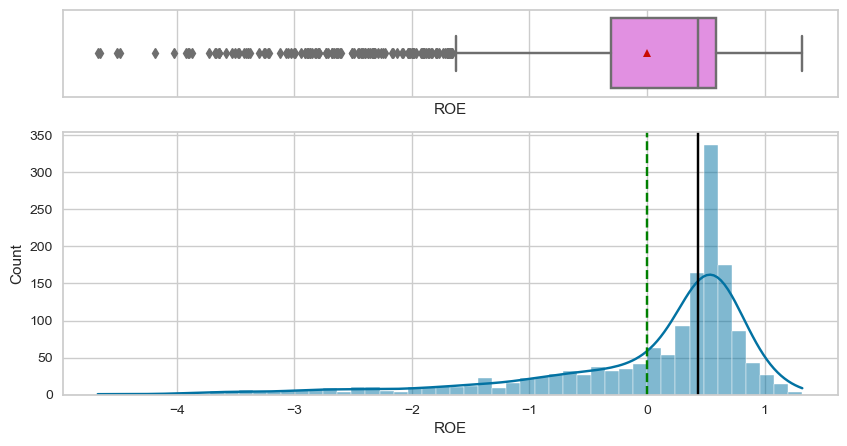

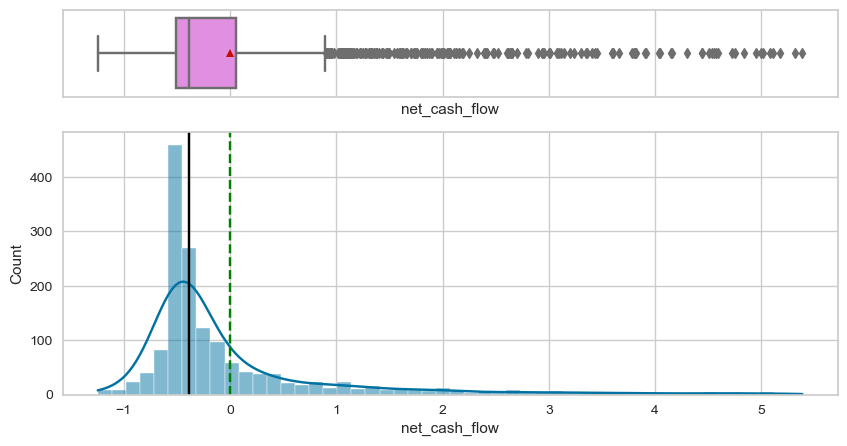

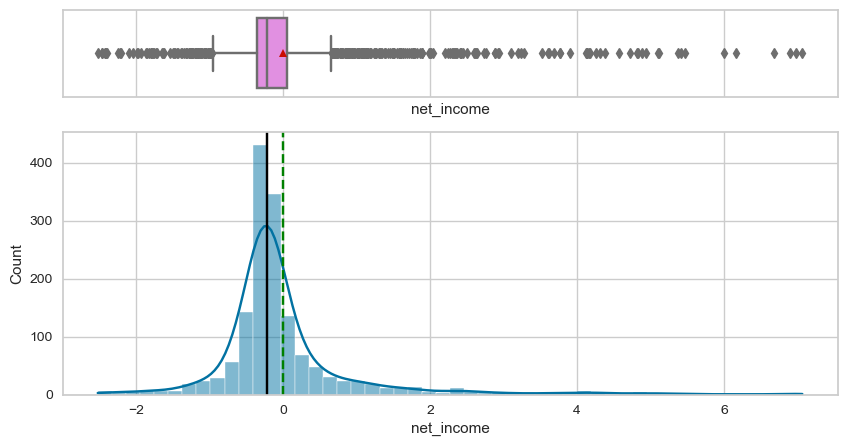

In [7]:
# see distributions of each feature

for f in features:
    histogram_boxplot(df_fin_scaled, f)

# 2. Clustering



## Silhouette analysis for choose k



In [8]:
def Silhouette_analysis(df):
    """
    This is a function for Silhouette analysis using k-means model
    :df: dataframe
    """
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    silhouette_avg = []

    for k in range_n_clusters:

        # initialise kmeans
        kmeans = KMeans(n_clusters=k, random_state=2049).fit(df)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg.append(silhouette_score(df, cluster_labels))

    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('number of clusters, K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis', fontsize=20)
    plt.show()

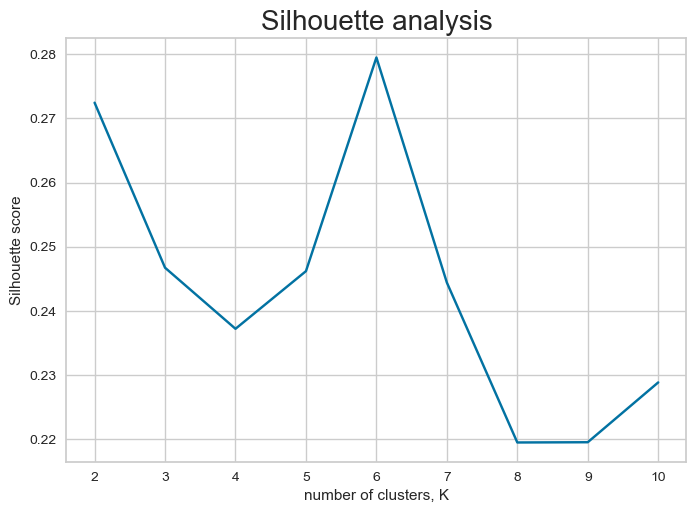

In [11]:
# Silhouette analysis to choose optimal k

Silhouette_analysis(df_fin_scaled)

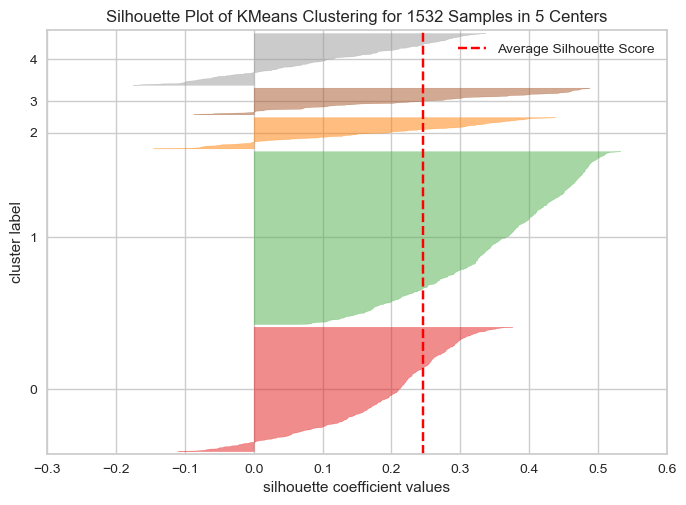

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1532 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
# visualize Silhouette scores with k-means model

num_clusters = 5

### changed FROM 6 TO 5 
# - Shiluette score is highest of ceters near 6 and it's not too large or too small 
# If any lower too large clusters and any higher over 7 too many so not so good for generalization 
# Random state changed from 2022 to 2049 since blade runner 
# we have random state since it makes it easier to replacate the result

visualizer = SilhouetteVisualizer(
    KMeans(num_clusters, random_state=2049)).fit(df_fin_scaled)
visualizer.show()

## Run model



In [13]:
# fit clustering model

# random state set to 2049
model = KMeans(n_clusters=num_clusters,
                random_state=2049).fit(df_fin_scaled)

# print out scores
print('Silhouette score: ',
      round(metrics.silhouette_score(df_fin_scaled, model.labels_, metric='euclidean'), 3))
print('Davies-Bouldin score: ',
      round(davies_bouldin_score(df_fin_scaled, model.labels_), 3))

# add cluster labels to data
df_fin_scaled['cluster'] = model.labels_



Silhouette score:  0.246
Davies-Bouldin score:  1.385


In [14]:
print(df_fin_scaled.shape)

(1532, 8)


### NOTES 


Silhouette score is higher then orginial code 
Also Bavies-Bouldin score is lower which means better clustering 


In [15]:
def sort_cluster_numbers(df, feature):
    """
    This is a function to sort cluster labels by a feature
    :df: dataframe
    :feature: a feature you want to sort by
    """

    as_is_list = df.groupby('cluster').median()[feature].sort_values(ascending=False).keys()
    to_be_list = range(1, num_clusters+1)

    df['cluster'] = df['cluster'].replace(dict(zip(as_is_list, to_be_list)))

In [16]:
# sort cluster labels by 'log_market_cap' for later convenience of analysis
# e.g., cluster 1 has the highest mean of 'log_market_cap'

sort_cluster_numbers(df_fin_scaled, feature='log_market_cap')

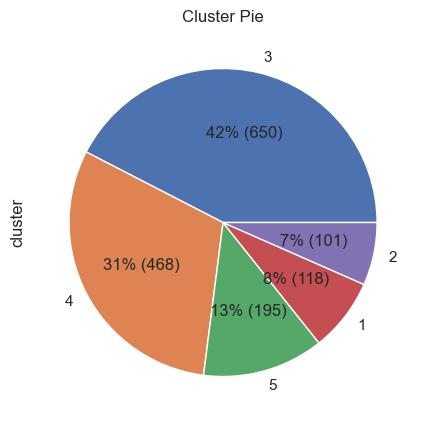

In [17]:
# plot pie chart to see cluster size 
# e.g., cluster 5 has 424 stocks and it takes 28% of all

sns.set()
counts = df_fin_scaled['cluster'].value_counts()
counts.plot(kind='pie', title='Cluster Pie', figsize=[5, 5],
            autopct=lambda p: '{:.0f}% ({:.0f})'.format(p, (p/100)*counts.sum()))
plt.show()

# 3. Clustering results



## scatterplot



In [18]:
def plot_scatterplot(df, features):
    """
    This is a function for scatterplot
    :df: dataframe
    :features: a list of features where you want to see distribtions
    """

    if len(features) == 2:
        g = sns.relplot(
            data=df, y=df[features[0]], x=df[features[1]], hue="cluster",  palette='gist_rainbow')  
        g.fig.suptitle("Clustering result with 2 features", fontsize=20)
        g.fig.subplots_adjust(top=0.9)

    elif len(features) == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        g = ax.scatter(df[features[0]], df[features[1]],
                       df[features[2]], c=df['cluster'], cmap='gist_rainbow')  
        ax.set_title('Clustering result with 3 features', fontsize=20)
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        legend = ax.legend(*g.legend_elements(), loc="center right",
                           title="cluster", borderaxespad=-8, ncol=1)
        ax.add_artist(legend)
    else:
        print('you can plot only 2 or 3 features')

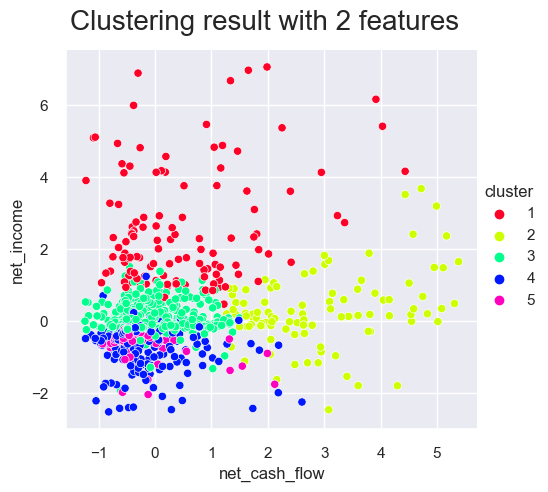

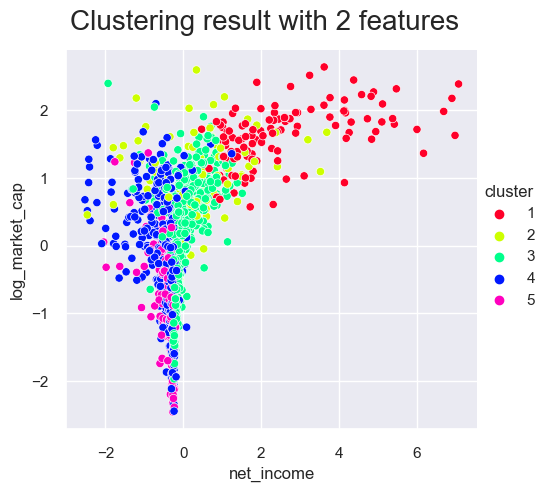

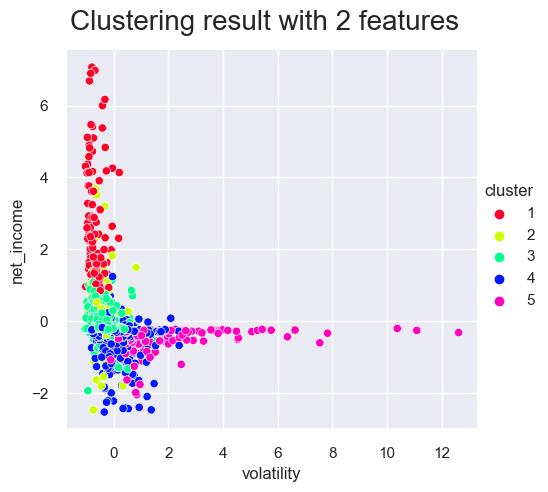

In [19]:
# clustering result with 2 features

#['log_market_cap', 'volatility', 'EPS',
#           'PER', 'ROE', 'net_cash_flow', 'net_income']

plot_scatterplot(df_fin_scaled, features=['net_income', 'net_cash_flow'])

plot_scatterplot(df_fin_scaled, features=['log_market_cap', 'net_income'])

plot_scatterplot(df_fin_scaled, features=['net_income', 'volatility'])




## Cluster comparison 


There is 5 clusters since we selected 5 cluster centers. Depending on graph drawn, some clusters are really distinct to each other and the others are blended together and they are difficult to seperate. However there is two really distinct clusters which are clusters 1 and 5. Clusters 3 and 4 are ususlly conected to each other. 

Overall, the borders of the clusters are not not very distinct. To help distinct clusters, we applied two different dimension reductions, t_SNE and Kernel PCA with rbf kernel. Data is multidimensional so we selected dimension reductions for multidimensional data. 

TSNE dimension reduction helped to make clusters more distinct to each other. Now, as we can see there is reasonable clusters. If dimension were even lower the clusters were more distinct. 

Kernel PCA with rbf kernel performed a little bit differently. In the end, there are distinct clusters but the borders are in some cases like with clusters 1 and 2 a little bit fizzy. This might higlight their similiraty more than can be seen on other graphs. 




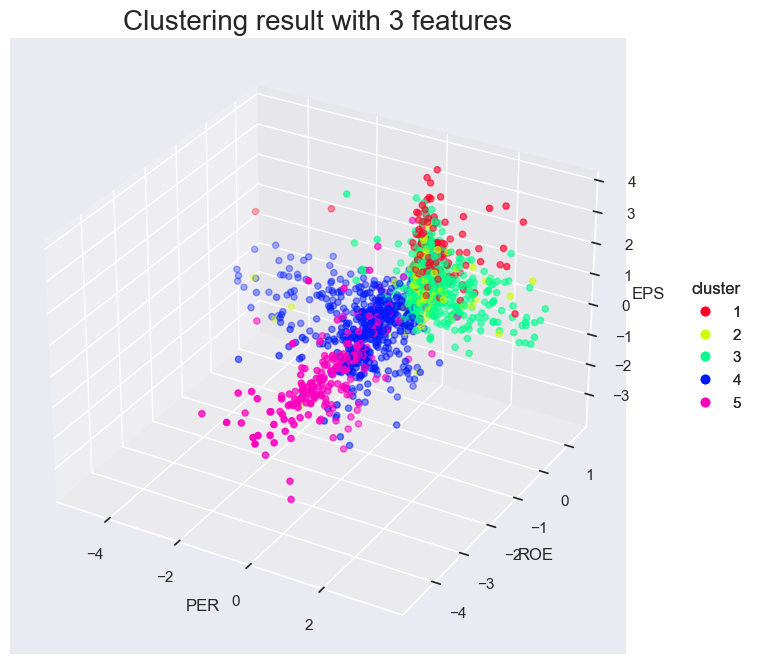

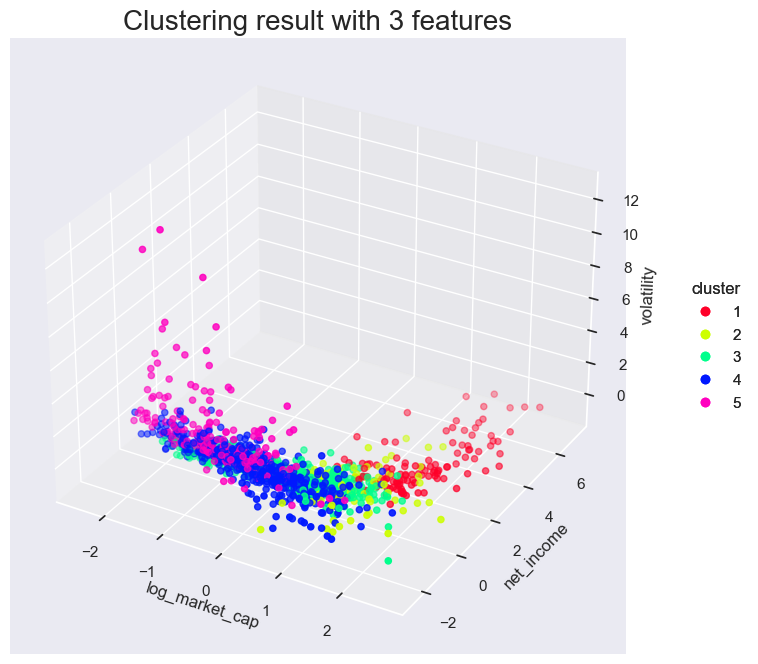

In [20]:
# clustering result with 3 features

plot_scatterplot(df_fin_scaled, features=['PER', 'ROE', 'EPS'])
plot_scatterplot(df_fin_scaled, features=['log_market_cap', 'net_income', 'volatility'])




In [21]:
def TSNE_2D(df):
    """
    This is a function for dimensionality reduction using TSNE
    :df: dataframe
    :return: a dataframe whose dimensionality is reduced to 2
    """

    tsne = TSNE(n_components=2, random_state=2)

    stocks = df.drop(columns=['cluster'])
    stocks_tsne = tsne.fit_transform(stocks)
    stocks_tsne_df = pd.DataFrame(
        stocks_tsne, columns=['t-SNE feature 1', 't-SNE feature 2'])
    stocks_tsne_df['cluster'] = list(df['cluster'])

    return stocks_tsne_df

In [22]:
def KERNELPCA(df, components): 

    kPCA = KernelPCA(n_components=components, kernel='rbf')

    stocks = df.drop(columns=['cluster'])
    stocks_kPCA = kPCA.fit_transform(stocks)
    stocks_kPCA_df = pd.DataFrame(
        stocks_kPCA, columns=['kPCA feature 1', 'kPCA feature 2'])
    stocks_kPCA_df['cluster'] = list(df['cluster'])

    return stocks_kPCA_df

In [23]:
df_TSNE_2D = TSNE_2D(df_fin_scaled)
df_kPCA_2D = KERNELPCA(df_fin_scaled, 2)


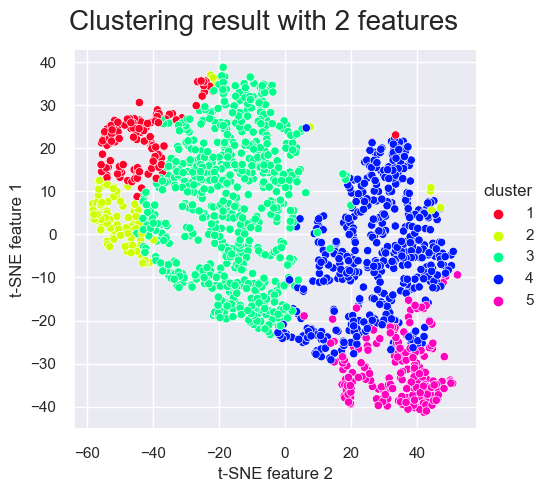

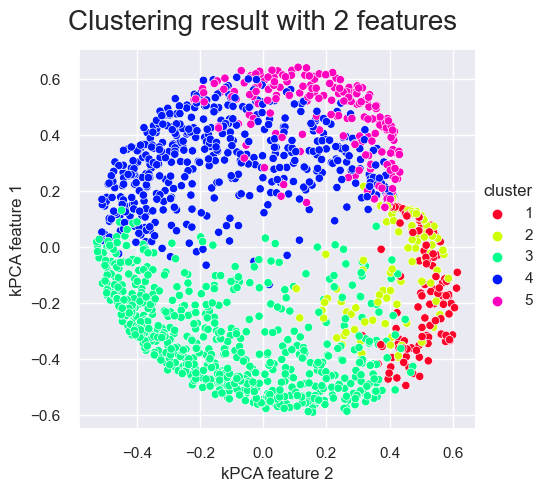

In [24]:
# clustering result with 2 TSNE features
# Clusetering result with 2 kPCA fetures 

df_TSNE_2D = TSNE_2D(df_fin_scaled)
df_kPCA_2D = KERNELPCA(df_fin_scaled, 2)

plot_scatterplot(df_TSNE_2D, features=['t-SNE feature 1', 't-SNE feature 2'])

plot_scatterplot(df_kPCA_2D, features=['kPCA feature 1', 'kPCA feature 2'])






# 4. Analysis


## Names of firms in cluster


In [25]:
def largest_firms(df, feature):
    """
    This is a function for listing five most popular firms in cluster
    :df: dataframe
    :feature: a feature you want to sort by
    :return: dataframe with names of largest firms with feature
    """
    
    
  # miksi ei toimi??  

    name_dict = {}

    k = len(df['cluster'].unique())
    #print(k)
    for i in range(1, k+1):
        df_cluster = df[df['cluster'] == i]
        df_cluster = df_cluster.sort_values(feature, ascending=False)
        name_dict['cluster_{}'.format(i)] = df_cluster['name'][:5].tolist()

    return pd.DataFrame(name_dict, index=range(1, 6))



In [26]:
# add cluster labels to data
df_fin['cluster'] = list(df_fin_scaled['cluster'])

# list five largest firms with 'market_cap' in cluster
df_fin_names = largest_firms(df_fin, feature='market_cap')
df_fin_names

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
1,INTUITIVE SURGICAL INC,FIDELITY NATIONAL INFO SVCS,DOMINION ENERGY INC,PINTEREST INC,NEW FORTRESS ENERGY INC
2,FISERV INC,KRAFT HEINZ CO,ZIMMER BIOMET HOLDINGS INC,ZENDESK INC,NOVAVAX INC
3,DUKE ENERGY CORP,MARRIOTT INTL INC,WILLIAMS COS INC,AVALARA INC,TG THERAPEUTICS INC
4,GLOBAL PAYMENTS INC,IQVIA HOLDINGS INC,ROLLINS INC,SAREPTA THERAPEUTICS INC,SEAWORLD ENTERTAINMENT INC
5,NORFOLK SOUTHERN CORP,KINDER MORGAN INC,AES CORP (THE),DENTSPLY SIRONA INC,PRECIGEN INC


## Financial Properties


In [27]:
def plot_boxplot(df, features):
    """
    This is a function for generating boxplot
    :df: dataframe
    :features: a list of features where you want to see distributions 
    """

    n_features = len(features)

    fig, axes = plt.subplots(1, n_features, figsize=(25, 5))
    for i in range(n_features):
        feature = df[features].columns[i]
        sns.boxplot(x="cluster", y=feature, data=df, ax=axes[i])
        axes[i].set_title("{}".format(feature), fontsize=15)
        axes[i].set_ylabel('')
    plt.show()

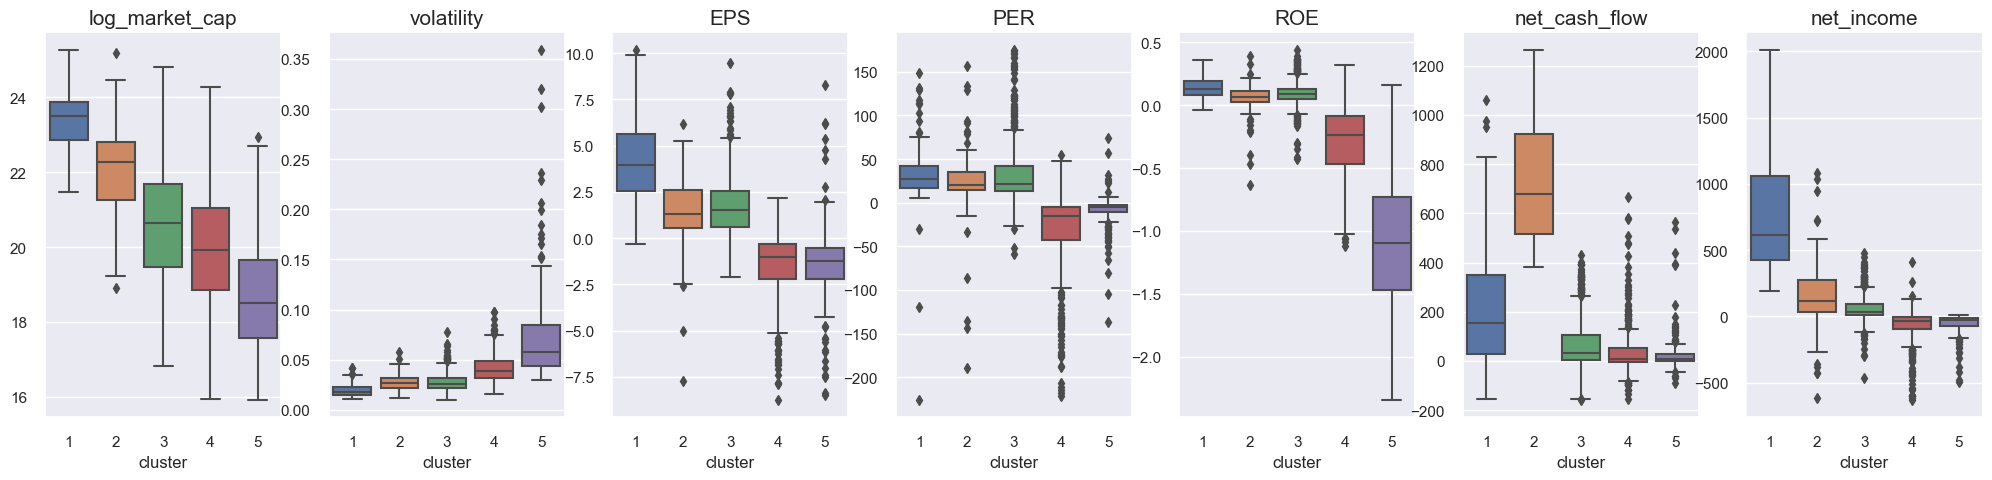

In [28]:
# plot boxplot of features

plot_boxplot(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                               'PER', 'ROE', 'net_cash_flow', 'net_income'])

## Boxplot and histogram analysis 


Market cap:

Market cap is highest in the first cluster,then following in ascending orer 1,2,3,4,5. Variation between market caps are highest in the clusters 3 and 4. Also thee is some outliers in cluster 2 and 5. 




Volatility 

Volatily fllows in same ascending order in 1,2,3,4,5. Volatility difference is largerst in the cluster 5 also ther is also most outliers. 



Earnings per share

Earnings per share is positve in clusters 1-3. This is in line to other earning ratios, as one could expect. Earnings are negative in clusters of 4 and 5. 

P/E Ratio 

P/E ration is postive in clusters 1-3. 

However in every cluster, there is some major outliers where the P/E ratio is really negative. In cluster 5 the P/E ratio is closer to zero than it is in cluster 4. 


Return of equity 

Return of equity is positive in clusters 1-3. This means that investors equity makes profits. In the other hand, REO is negative in clusters 4 and 5. 


Net income and net cf

Net income is similar to the sizes of the market cap. The net income is larger ascending in size from 1-5. 1-3 are mostly positive and 4,5 is mostly negative. 
Net cf is mainly positive in the all of the clusters. It is biggest in 2nd cluster. 




Distributions amongst the clusters are quite narrow. But it varies a little bit among the different clusters.  

In [29]:
def plot_histogram(df, features):
    """
    This is a function for generating histogram
    :df: dataframe 
    :features: a list of features where you want to see distributions 
    """
    for i in range(len(features)):
        g = sns.FacetGrid(df, col='cluster')
        g.map_dataframe(sns.histplot, x=features[i], bins=30)

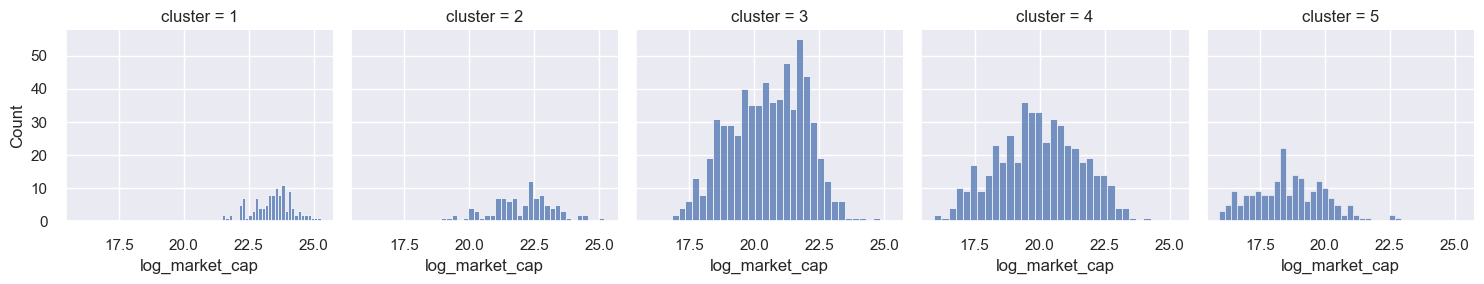

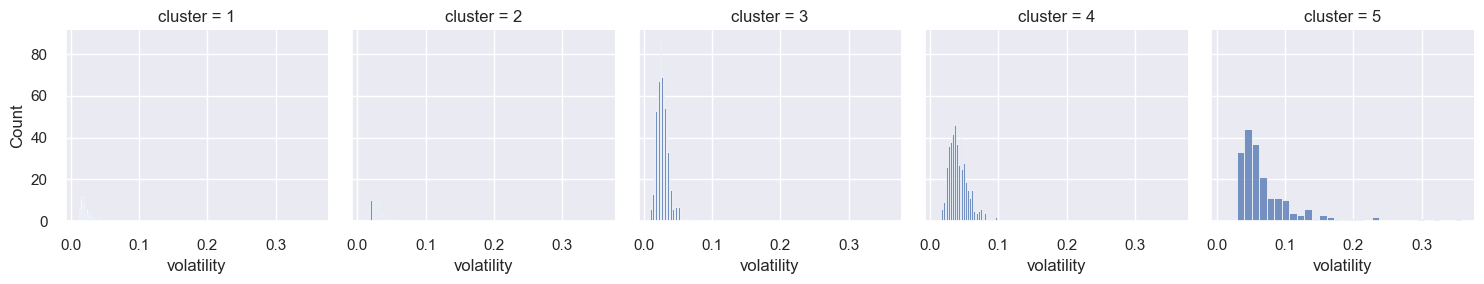

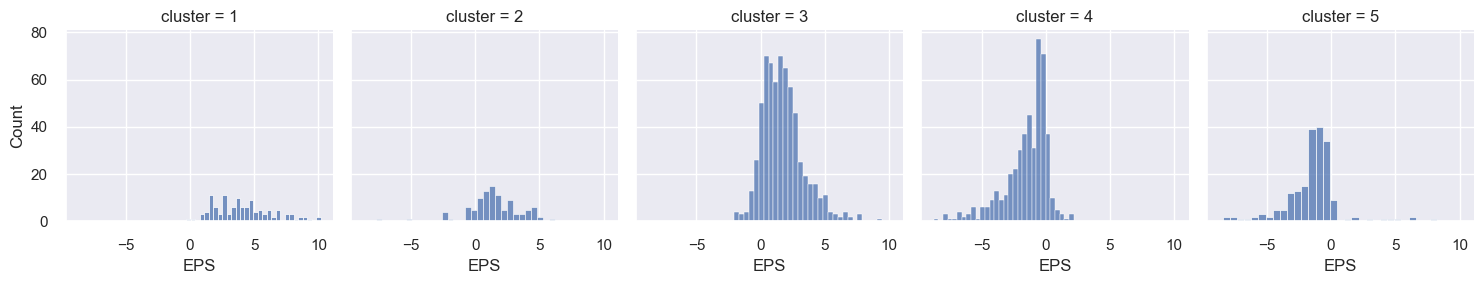

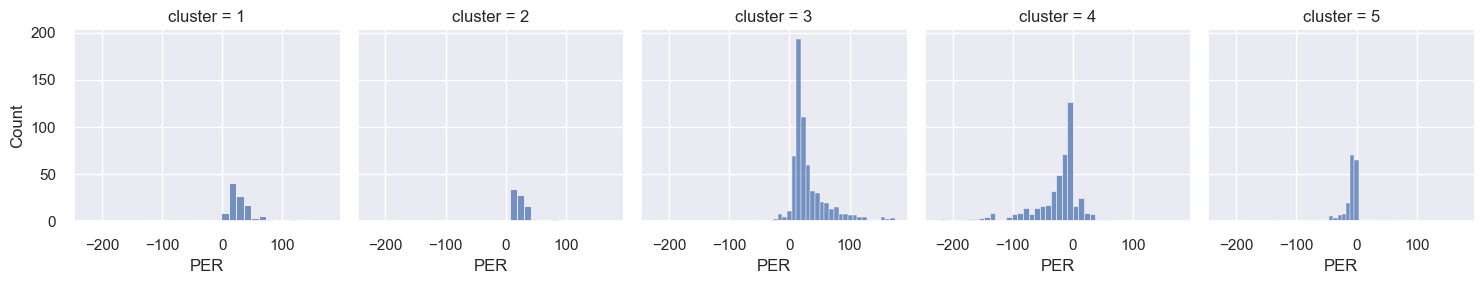

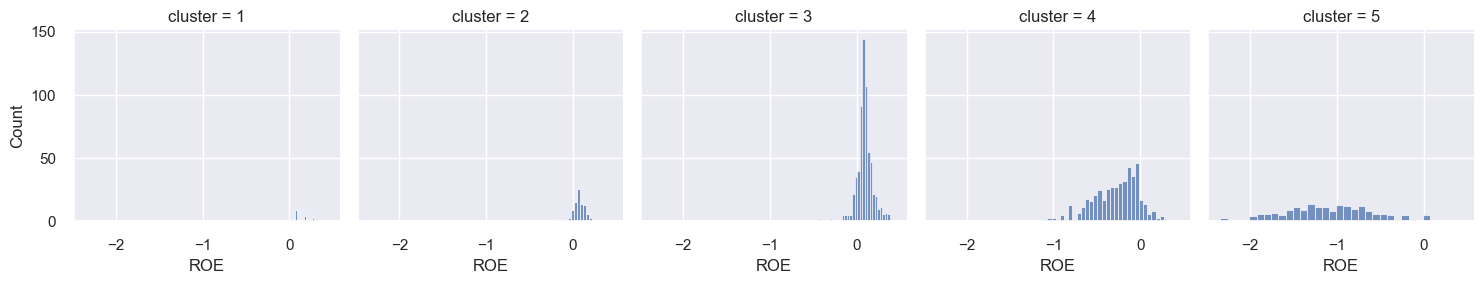

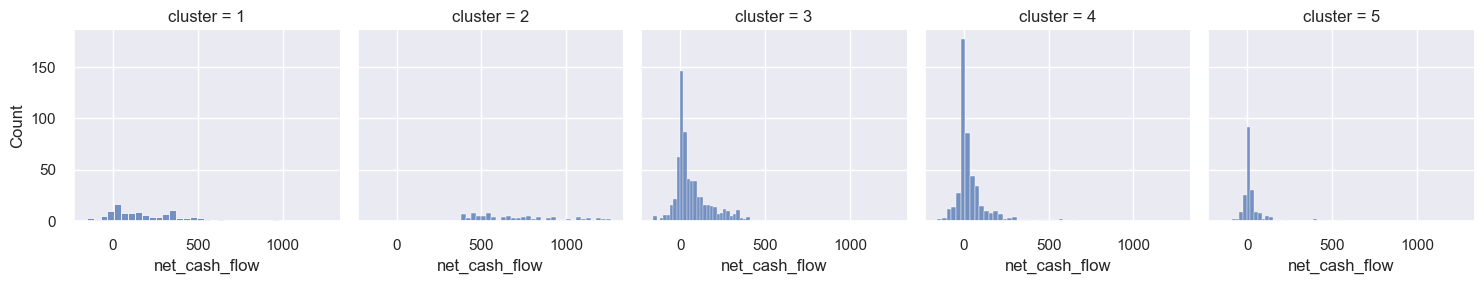

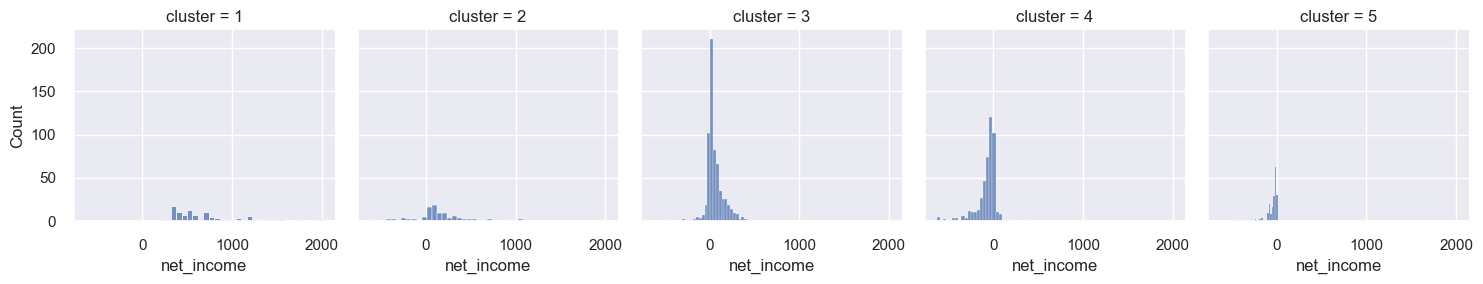

In [30]:
# plot histogram

plot_histogram(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                                 'PER', 'ROE', 'net_cash_flow', 'net_income'])

In [31]:
def plot_mean_table(df, features):
    """
    This is a function for generating mean table
    :df: dataframe
    :features: a list of features where you want to see mean values
    """

    df_copied = df.copy()
    df_copied = df_copied[features+['cluster']]

    # calculate mean values for each cluster
    df_table = df_copied.groupby('cluster').mean()

    # color dataframe
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    df_table = df_table.style.background_gradient(cmap=cm)
    display(df_table)

In [32]:
plot_mean_table(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                                  'PER', 'ROE', 'net_cash_flow', 'net_income'])

,log_market_cap,volatility,EPS,PER,ROE,net_cash_flow,net_income
cluster,,,,,,,
1,23.404222,0.019824,4.222288,31.678576,0.144322,215.821703,768.956508
2,22.048389,0.027700,1.454327,22.388455,0.052178,728.816921,149.174703
3,20.509398,0.027469,1.724492,32.758043,0.091522,67.769185,61.582229
4,19.954212,0.041331,-1.474679,-31.326821,-0.286953,37.955878,-74.669639
5,18.633395,0.073455,-1.468528,-9.559144,-1.090477,28.173010,-54.557323


## Plot mean table analysis 

Large market cap cluster the market cap, eps, p/e r, roe and net income are the largest. 

In 2nd cluster the mean net cf is largest and it ranks second on behind the 1 st. 

In 3rd cluster Ernings per share is the largest. However return of investment is not the largest so the group might offer interesting opportunities. 

in 4th and 5th cluster the P/E ratio and ernings and net income is negative so they don't make profity. Also their volatility is the largest. Thus they are not might not be the best investments. 




## Market behavior



In [33]:
def get_corr_and_return(df_in):
    """
    This is a function for calculating 
    (1) return correlations and (2) mean and standard deviation of returns over 6 months (Jan 2021 ~ Jul 2021)

    :df_in: dataframe
    :return avg_intra_list: a list of average intra correlations of each cluster
    :return avg_inter_list: a list of average inter correlations between clusters
    :return mu: mean of daily log returns of each cluster
    :return Sigma: a variance-covariance matrix between clusters
    """

    df = df_in.copy()

    # create a dictionary (key: cluster number, item: tic list)
    tic_list_dict = {}
    for key, value in df.groupby('cluster'):
        tic_list_dict[key] = list(value['tic'])

    # filter stocks
    daily_price = df_daily[df_daily['tic'].isin(list(df['tic']))].sort_values('datadate')

    # calculate log returns from daily close price
    n_clusters = len(df['cluster'].unique())
    daily_logret_dict = {}
    for k in range(1, n_clusters+1):
        # daily close price (for each cluster)
        prices = daily_price[daily_price['tic'].isin(tic_list_dict[k])]
        # daily close price (for each stock)
        df_close_dict = {}
        for tic in tic_list_dict[k]:
            price = prices[prices['tic'] == tic]['prccd'].values
            if len(price) == 126:
                df_close_dict[tic] = price
        df_close = pd.DataFrame.from_dict(df_close_dict)
        # log return transformation
        df_logret = np.log(df_close/df_close.shift(1))
        df_logret = df_logret.drop(0) # drop NaN value at the first day 

        daily_logret_dict[k] = df_logret

    # calculate average intra-correlations
    avg_intra_list = []
    for k in range(1, n_clusters+1):
        df_corr = daily_logret_dict[k].corr()
        df_corr['sum'] = df_corr.sum(axis=1) - 1
        df_corr['avg'] = df_corr['sum']/(len(df_corr)-1)
        avg_intra_list.append(df_corr['avg'].mean())

    # calculate average inter-correlations
    daily_logret_corr = pd.concat(daily_logret_dict, axis=1).corr()
    avg_inter_list = []
    for i in range(1, n_clusters):
        for j in range(i+1, n_clusters+1):
            rectangle = daily_logret_corr.loc[i, j]
            avg = np.nanmean(rectangle)
            avg_inter_list.append(avg)

    # calculate mean and covariance of returns between clusters (for 6 months)
    avg_logret_dict = {}
    for k in range(1, n_clusters+1):
        avg_logret_dict['cluster_{}'.format(
            k)] = daily_logret_dict[k].mean(axis=1)
    avg_logret_df = pd.DataFrame(avg_logret_dict)

    mu = avg_logret_df.mean() * len(avg_logret_df)  # annualization (126 days)
    Sigma = avg_logret_df.cov() * len(avg_logret_df)  # annualization (126 days)

    return avg_intra_list, avg_inter_list, mu, Sigma

In [34]:
# get correlations and returns

avg_intra_list, avg_inter_list, mu, Sigma = get_corr_and_return(df_fin)

In [35]:
def plot_corr_table(avg_intra_list, avg_inter_list):
    """
    This is a function to plot correlations table
    :avg_intra_list: a list of average intra correlations of each cluster
    :avg_inter_list: a list of average intra correlations of between clusters
    """

    # some functions for plot
    cmap = copy.copy(plt.cm.get_cmap("Blues"))
    cmap.set_under("white")
    def color_nan_white(val):
        """Color the nan text white"""
        if np.isnan(val):
            return 'color: white'
    def color_nan_white_background(val):
        """Color the nan cell background white"""
        if np.isnan(val):
            return 'background-color: white'
    
    # create a matrix whose diagonal elements are average intra-correlations and off-diagonal elements are average inter-correlations
    n_clusters = len(avg_intra_list)
    corr_matrix = np.zeros((n_clusters, n_clusters))
    np.fill_diagonal(corr_matrix, avg_intra_list)

    indices = np.triu_indices(n_clusters, 1)
    corr_matrix[indices] = avg_inter_list
    corr_matrix = pd.DataFrame(corr_matrix)

    # fill 0s with NaNs
    corr_matrix = corr_matrix.replace(0, np.nan)
    # modify names
    corr_matrix.columns = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    corr_matrix.index = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    # color dataframe
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    corr_matrix = corr_matrix.style.background_gradient(cmap=cm).applymap(
        lambda x: color_nan_white(x)).applymap(lambda x: color_nan_white_background(x))
    display(corr_matrix)

In [40]:
# plot correlations table where
# diagonal elements are average intra-correlations
# off-diagonal elements are average inter-correlations

plot_corr_table(avg_intra_list, avg_inter_list)

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
Cluster_1,0.255259,0.274504,0.219638,0.128155,0.082071
Cluster_2,nan,0.393416,0.310432,0.186054,0.126124
Cluster_3,nan,nan,0.254612,0.162725,0.115936
Cluster_4,nan,nan,nan,0.179513,0.176348
Cluster_5,nan,nan,nan,nan,0.203798


## CORR

Cluster 1 has lowest correlation between the cluster 5. then in descending order to 2,3,4. Correlation is quite high between 1-2 and 1-3

Cluster 2 and 3 share high correlation between each other. 3rd cluster but cluster 3 doesn't have that high correlation between 4 and 5. 

4-5 correlation is higest amongs the correlations to 5. But in general 4th cluster have only moderate level of correlation with every other cluster but 5 has only higer correlation to 4th cluster. 


Clusters 1-3 are their own group and the 4-5 are other group. 



Correlations inside clusters are quite highest in cluster 2 so they form most dense group. Then amongs 1,3 and at after that 4,5. But in general groups own correlation is higher in their own group. 

In [37]:
def plot_return_and_risk(mu, Sigma):
    """
    This is a function to create a scatterplot of mean and standard deviation of returns of clusters
    """

    return_df = pd.DataFrame(
        {'Mean': mu.values, 'Standard Deviation': np.diag(Sigma)}, index=mu.index)
    return_df['Method'] = 'clustering'
    return_df = return_df.reset_index()

    g = sns.lmplot(
        data=return_df,
        x="Standard Deviation", y="Mean", hue="Method",
        height=5,
        scatter_kws={"s": 200},
        ci=None, fit_reg=False  # turn off the shade and line
    )

    g.set_axis_labels("Standard Deviation", "Mean")
    plt.title('Return and Risk', fontsize=20)
    plt.ylim(-0, 0.3)

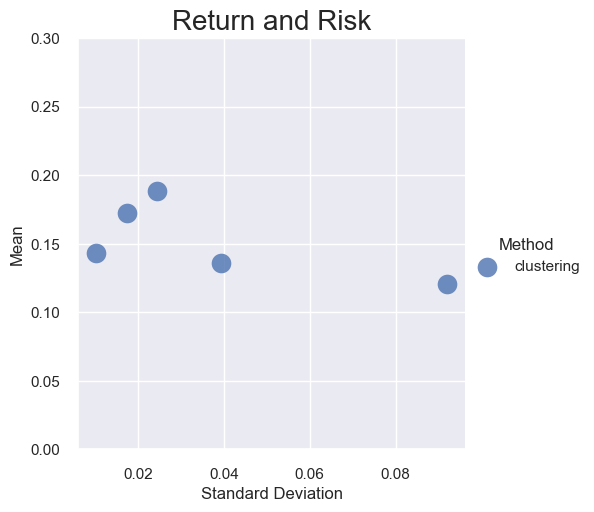

In [38]:
plot_return_and_risk(mu, Sigma)

## Return and risk

Clusters on the left where mean is high and standard deviation is low are better than clusters on the right were mean return is low and standard deviation is high. 